In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In [3]:
df = pd.read_csv('cleaned_sales.csv', parse_dates=['date'])
df.sort_values('date', inplace=True)

In [5]:
# Drop unnecessary  columns
drop_cols = ['customer_name', 'mobile_number', 'product_name']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [7]:
# Create lag features
df['revenue_lag1'] = df['revenue'].shift(1)
df['rolling_mean_7'] = df['revenue'].rolling(window=7, min_periods=1).mean()

In [9]:
# Drop NaNs created by lagging
df.dropna(inplace=True)

In [11]:
# One-hot encode categorical columns 
categorical_cols = df.select_dtypes(include='object').columns.drop('date', errors='ignore')
df_encoded = pd.get_dummies(df, columns=categorical_cols)

In [13]:
# Train-Test Split (80/20 Time-based)
target = 'revenue'
date_col = 'date'
features = [col for col in df_encoded.columns if col not in [date_col, target]]

train_size = int(len(df_encoded) * 0.8)
train, test = df_encoded.iloc[:train_size], df_encoded.iloc[train_size:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [15]:
# ARIMA Model (Time Series)
arima_data = train[[date_col, target]].copy()
arima_data = arima_data.groupby(date_col).sum()
arima_series = arima_data[target]
arima_series.index = pd.DatetimeIndex(arima_series.index)
arima_series = arima_series.asfreq('D').ffill()

arima_model = ARIMA(arima_series, order=(5, 1, 0))
arima_result = arima_model.fit()

forecast_arima = arima_result.forecast(steps=len(test))

In [17]:
# Random Forest Model 
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [19]:
# XGBoost Model 
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


In [21]:
# Evaluation Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nModel Evaluation Metrics ")
print(f"{'Model':<15}{'MAE':>10}{'RMSE':>10}{'MAPE (%)':>15}")
print("-" * 45)

results = {
    'ARIMA': (test[target], forecast_arima),
    'Random Forest': (y_test, rf_preds),
    'XGBoost': (y_test, xgb_preds),
}

for model_name, (y_true, y_pred) in results.items():
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name:<15}{mae:>10.2f}{rmse:>10.2f}{mape:>15.2f}")


Model Evaluation Metrics 
Model                 MAE      RMSE       MAPE (%)
---------------------------------------------
ARIMA           238194.11 250228.60         519.02
Random Forest     8205.24  11360.28          11.12
XGBoost          11965.07  16914.84          15.61


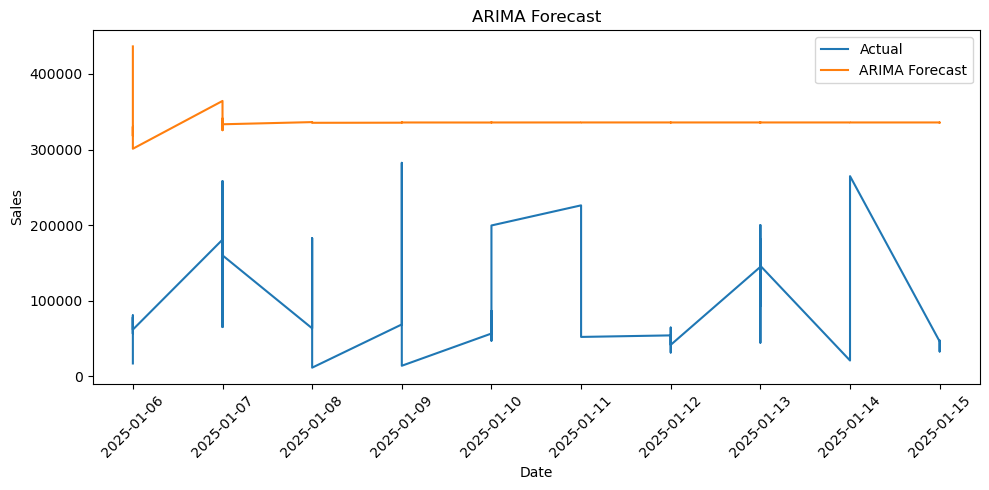

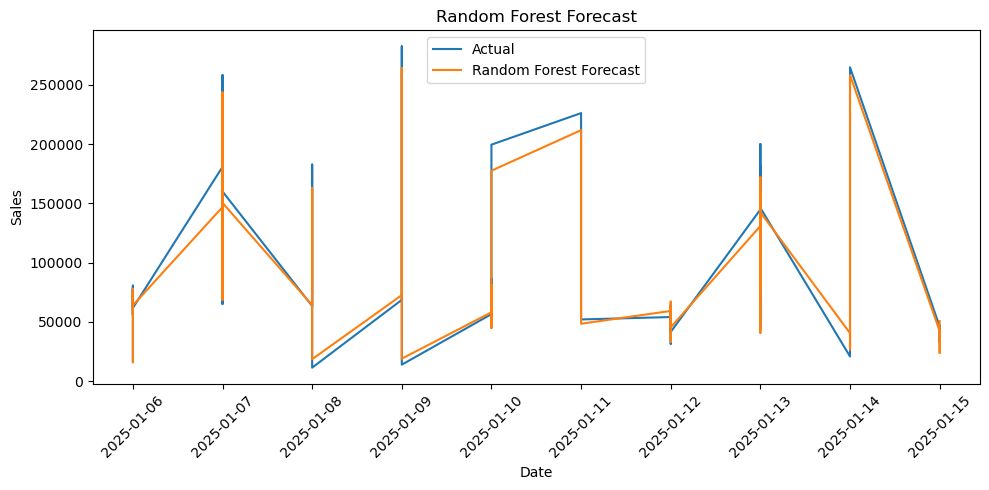

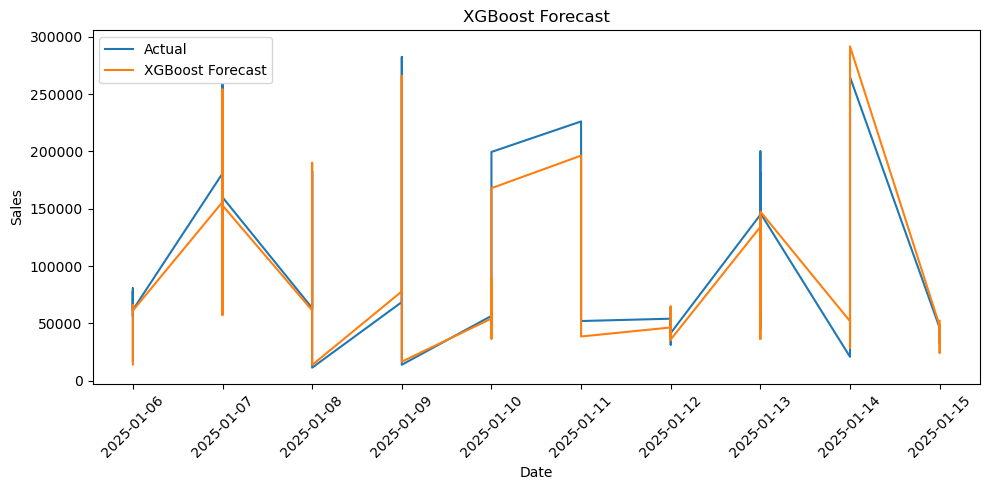

In [23]:
# Plotting Forecasts
def plot_forecast(dates, actual, predicted, title):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, label='Actual')
    plt.plot(dates, predicted, label=title)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(test[date_col], test[target], forecast_arima, 'ARIMA Forecast')
plot_forecast(test[date_col], y_test, rf_preds, 'Random Forest Forecast')
plot_forecast(test[date_col], y_test, xgb_preds, 'XGBoost Forecast')


In [25]:
# Save Models and Feature Info
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(arima_result, 'arima_model.pkl')
joblib.dump(features, 'trained_features.pkl')

print("\n✅ Models and feature list saved successfully!")


✅ Models and feature list saved successfully!
